In [1]:
from torch.autograd import Variable
from methods_helper import *

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.ndimage.filters import gaussian_filter

import torch.nn as nn
from torch import Tensor
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms

import argparse

import scipy
import os
import cv2
import json
import imageio
import numpy as np
from PIL import Image

import matplotlib
from matplotlib import pyplot as plt

from tqdm import tqdm
from sklearn import metrics

/tmp/ipykernel_694583/3221472997.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
size=224
init(size)

In [3]:
data_transform = transforms.Compose(
    [
        transforms.Resize(
            (224,224), interpolation=transforms.InterpolationMode.BICUBIC
        ),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image = data_transform(image)
    return image

def preprocess_input(images):
    """
    Input:
        image: An image read by opencv [b,w,h,c]
    Output:
        outputs: After preproccessing, is a tensor [c,w,h]
    """
    outputs = []
    for image in images:
        image = Image.fromarray(image)
        image = data_transform(image)
        outputs.append(image)
    return torch.stack(outputs)

In [4]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [5]:
def iGOS_pp(
        model,
        images,
        baselines,
        labels,
        size=28,
        iterations=20,
        ig_iter=20,
        L1=10,
        L2=20,
        alpha=1000,
        softmax=True,
        **kwargs):
    """
        Generates explanation by optimizing a separate masks for insertion and deletion.
        Paper title:  iGOS++: Integrated Gradient Optimized Saliency by Bilateral Perturbations
        Link to the paper: https://arxiv.org/pdf/2012.15783.pdf

    :param model:
    :param images:
    :param baselines:
    :param labels:
    :param size:
    :param iterations:
    :param ig_iter:
    :param L1:
    :param L2:
    :param alpha:
    :param softmax:
    :param kwargs:
    :return:
    """
    def regularization_loss(images, masks):
        return L1 * torch.mean(torch.abs(1 - masks).view(masks.shape[0], -1), dim=1) + \
               L2 * bilateral_tv_norm(images, masks, tv_beta=2, sigma=0.01)

    def ins_loss_function(up_masks, indices, noise=True):
        losses = -interval_score(
                    model,
                    baselines[indices],
                    images[indices],
                    labels[indices],
                    up_masks,
                    ig_iter,
                    output_func,
                    noise
                    )
        return losses.sum(dim=1).view(-1)

    def del_loss_function(up_masks, indices, noise=True):
        losses = interval_score(
                    model,
                    images[indices],
                    baselines[indices],
                    labels[indices],
                    up_masks,
                    ig_iter,
                    output_func,
                    noise,
                    )
        return losses.sum(dim=1).view(-1)

    def loss_function(up_masks, masks, indices):
        loss = del_loss_function(up_masks[:, 0], indices)
        loss += ins_loss_function(up_masks[:, 1], indices)
        loss += del_loss_function(up_masks[:, 0] * up_masks[:, 1], indices)
        loss += ins_loss_function(up_masks[:, 0] * up_masks[:, 1], indices)
        return loss + regularization_loss(images[indices], masks[:, 0] * masks[:, 1])

    masks_del = torch.ones((images.shape[0], 1, size, size), dtype=torch.float32, device='cuda')
    masks_del = Variable(masks_del, requires_grad=True)
    masks_ins = torch.ones((images.shape[0], 1, size, size), dtype=torch.float32, device='cuda')
    masks_ins = Variable(masks_ins, requires_grad=True)

    if softmax:
        output_func = softmax_output
    else:
        logit_output.original = torch.gather(torch.nn.Sigmoid()(model(images)), 1, labels.view(-1,1))
        output_func = logit_output

    for i in range(iterations):
        up_masks1 = upscale(masks_del)
        up_masks2 = upscale(masks_ins)

        # Compute the integrated gradient for the combined mask, optimized for deletion
        integrated_gradient(model, images, baselines, labels, up_masks1 * up_masks2, ig_iter, output_func)
        total_grads1 = masks_del.grad.clone()
        total_grads2 = masks_ins.grad.clone()
        masks_del.grad.zero_()
        masks_ins.grad.zero_()

        # Compute the integrated gradient for the combined mask, optimized for insertion
        integrated_gradient(model, baselines, images, labels, up_masks1 * up_masks2, ig_iter, output_func)
        total_grads1 -= masks_del.grad.clone()  # Negative because insertion loss is 1 - score.
        total_grads2 -= masks_ins.grad.clone()
        masks_del.grad.zero_()
        masks_ins.grad.zero_()

        # Compute the integrated gradient for the deletion mask
        integrated_gradient(model, images, baselines, labels, up_masks1, ig_iter, output_func)
        total_grads1 += masks_del.grad.clone()
        masks_del.grad.zero_()

        # Compute the integrated graident for the insertion mask
        integrated_gradient(model, baselines, images, labels, up_masks2, ig_iter, output_func)
        total_grads2 -= masks_ins.grad.clone()
        masks_ins.grad.zero_()

        # Average them to balance out the terms with the regularization terms
        total_grads1 /= 2
        total_grads2 /= 2

        # Computer regularization for combined masks
        losses = regularization_loss(images, masks_del * masks_ins)
        losses.sum().backward()
        total_grads1 += masks_del.grad.clone()
        total_grads2 += masks_ins.grad.clone()

        masks = torch.cat((masks_del.unsqueeze(1), masks_ins.unsqueeze(1)), 1)
        total_grads = torch.cat((total_grads1.unsqueeze(1), total_grads2.unsqueeze(1)), 1)
        alphas = line_search(masks, total_grads, loss_function, alpha)

        masks_del.data -= total_grads1 * alphas
        masks_ins.data -= total_grads2 * alphas
        masks_del.grad.zero_()
        masks_ins.grad.zero_()
        masks_del.data.clamp_(0,1)
        masks_ins.data.clamp_(0,1)

    return masks_del * masks_ins

In [6]:
explainer = iGOS_pp

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Instantiate model
vis_model = models.resnet101(pretrained = True)
vis_model.eval()
vis_model.to(device)
print("load ResNet-101 model")

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load ResNet-101 model


In [9]:
image_path = "../../examples/dog_image.jpg"
img = cv2.imread(image_path)
img = cv2.resize(img, (224,224))

data_input = transform_vision_data(img)

In [5]:
baseline_img = np.zeros((224,224,3))
baseline_data = transform_vision_data(baseline_img.astype(np.uint8))

In [8]:
baseline_data[:,0,0]

tensor([-1.7923, -1.7521, -1.4802])

In [12]:
label = vis_model(data_input.unsqueeze(0).to(device)).argmax(-1)

In [15]:
label

tensor([212], device='cuda:0')

In [11]:
cam = explainer(vis_model, 
                images=data_input.detach().unsqueeze(0).to(device),
                baselines=baseline_data.unsqueeze(0).to(device),
                labels = label,
                size = 28
                )

In [12]:
explanation = cv2.resize(-cam[0][0].detach().cpu().numpy(),
                         (224,224))

In [13]:
def perturbed(image, mask, rate = 0.5, mode = "insertion"):
    mask_flatten = mask.flatten()
    number = int(len(mask_flatten) * rate)
    
    if mode == "insertion":
        new_mask = np.zeros_like(mask_flatten)
        index = np.argsort(-mask_flatten)
        new_mask[index[:number]] = 1

        
    elif mode == "deletion":
        new_mask = np.ones_like(mask_flatten)
        index = np.argsort(mask_flatten)
        new_mask[index[:number]] = 0
    
    new_mask = new_mask.reshape((mask.shape[0], mask.shape[1], 1))
    
    perturbed_image = image * new_mask
    return perturbed_image.astype(np.uint8)

In [14]:
steps = 50
insertion_explanation_images = []
deletion_explanation_images = []
for i in range(1, steps+1):
    perturbed_rate = i / steps
    insertion_explanation_images.append(perturbed(img, explanation, rate = perturbed_rate, mode = "insertion"))
    deletion_explanation_images.append(perturbed(img, explanation, rate = perturbed_rate, mode = "deletion"))

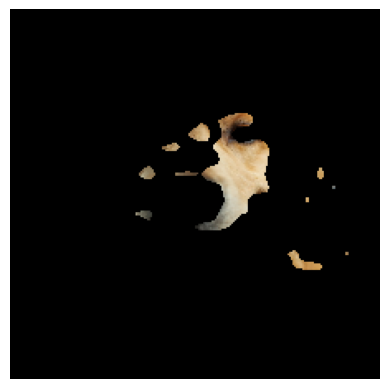

In [15]:
imshow(insertion_explanation_images[1])

In [16]:
device = "cpu"
vis_model.to(device)
print("ok")

ok


In [17]:
insertion_explanation_images_input = preprocess_input(
    np.array(insertion_explanation_images)
).to(device)
deletion_explanation_images_input = preprocess_input(
    np.array(deletion_explanation_images)
).to(device)

In [18]:
insertion_explanation_images_input_results = vis_model(insertion_explanation_images_input)
deletion_explanation_images_input_results = vis_model(deletion_explanation_images_input)

In [19]:
json_file = {}
json_file["consistency_score"] = insertion_explanation_images_input_results.softmax(-1)[:,label[0]].cpu().tolist()
json_file["collaboration_score"] = deletion_explanation_images_input_results.softmax(-1)[:,label[0]].cpu().tolist()

In [20]:
def visualization(image, attribution_map, saved_json_file, vis_image, index=None):
    
    insertion_ours_images = []
    # deletion_ours_images = []

    insertion_image = image - image
    insertion_ours_images.append(insertion_image)
    # deletion_ours_images.append(image - insertion_image)
    for i in range(1, len(saved_json_file["consistency_score"])+1):
        insertion_ours_images.append(
            perturbed(image, attribution_map, rate = i/(len(saved_json_file["consistency_score"])), mode = "insertion"))
    
    insertion_ours_images_input_results = np.array([saved_json_file["collaboration_score"][-1]] + saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [i/len(saved_json_file["collaboration_score"]) for i in range(0, len(insertion_ours_images_input_results))]
    # i = len(x)

    fig, [ax1, ax2, ax3] = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 1.5]}, figsize=(30,8))
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Attribution Map', fontsize=54)
    ax1.set_facecolor('white')
    ax1.imshow(vis_image[...,::-1].astype(np.uint8))
    
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(True)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Searched Region', fontsize=54)
    ax2.set_facecolor('white')
    ax2.set_xlabel("Highest conf. {:.4f}".format(insertion_ours_images_input_results.max()), fontsize=44)
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1))
    
    ax3.set_ylabel('Recognition Score', fontsize=44)
    ax3.set_xlabel('Percentage of image revealed', fontsize=44)
    ax3.tick_params(axis='both', which='major', labelsize=36)

    x_ = x#[:i]
    ours_y = insertion_ours_images_input_results#[:i]
    ax3.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve
    ax3.set_facecolor('white')
    ax3.spines['bottom'].set_color('black')
    ax3.spines['bottom'].set_linewidth(2.0)
    ax3.spines['top'].set_color('none')
    ax3.spines['left'].set_color('black')
    ax3.spines['left'].set_linewidth(2.0)
    ax3.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax3.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax3.fill_between(x_, ours_y, color='dodgerblue', alpha=0.1)

    kernel = np.ones((3, 3), dtype=np.uint8)
    # ax3.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线
    ax3.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    if ours_best_index != 0:
        dilate = cv2.dilate(mask, kernel, 3)
        # erosion = cv2.erode(dilate, kernel, iterations=3)
        # dilate = cv2.dilate(erosion, kernel, 2)
        edge = dilate - mask
        # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    if ours_best_index != 0:
        image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])
    
    auc = metrics.auc(x, insertion_ours_images_input_results)
    ax3.set_title('Insertion {:.4f}'.format(auc), fontsize=54)

In [21]:
def gen_cam(image, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    # image = cv2.resize(cv2.imread(image_path), (224,224))
    # mask->heatmap
    heatmap = cv2.applyColorMap(np.uint8(mask*255), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam, (heatmap).astype(np.uint8)

def norm(image):
    """
    :param image: [H,W]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    
    return image

In [22]:
im, heatmap = gen_cam(img, norm(explanation))

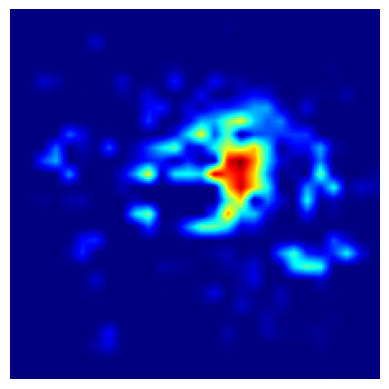

In [23]:
imshow(heatmap)

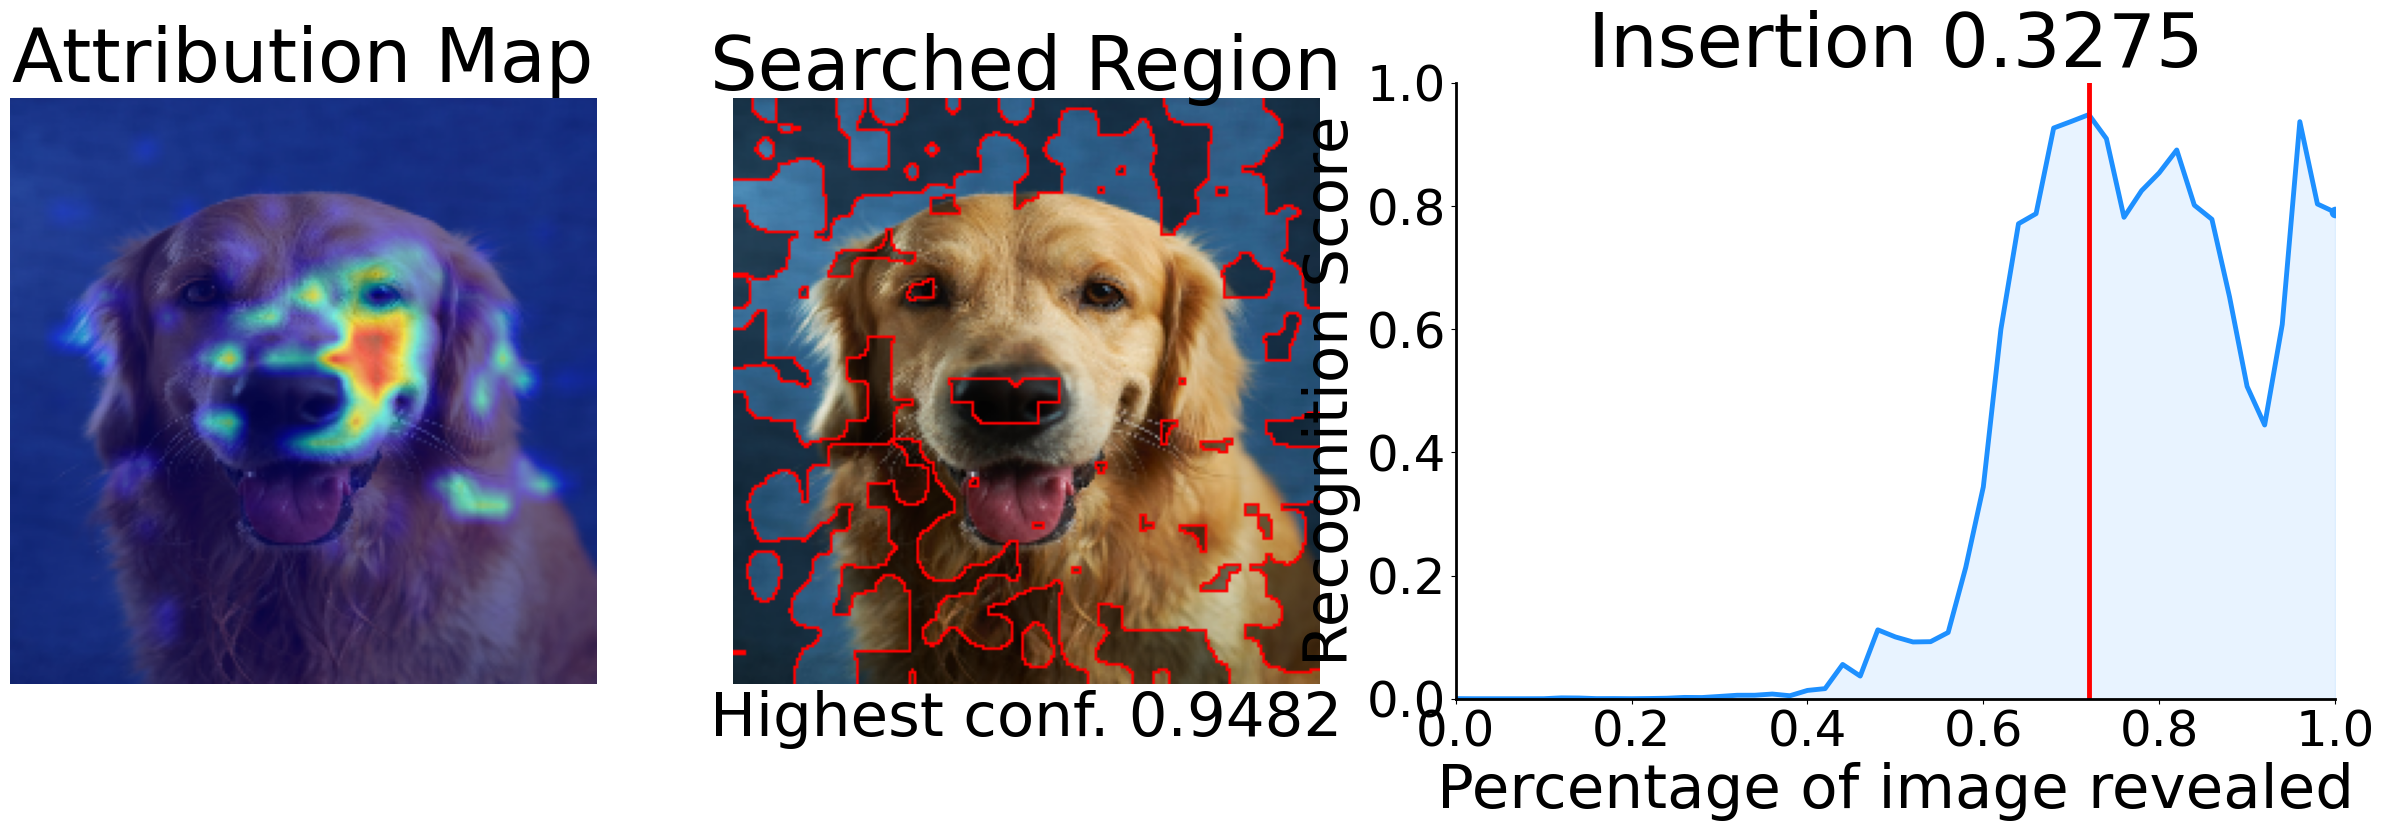

In [24]:
visualization(img, explanation, json_file, im)